In [51]:
from tqdm import tqdm
import torch

import torch_scatter
import torch_geometric
verbose = True

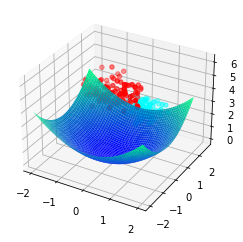

In [52]:
# show some 3d-point cloud data.
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import numpy as np

class Id(nn.Module):
    def __init__(self):super().__init__()
    def forward(self, x):return x

fig = plt.figure()
ax = plt.axes(projection = '3d')

scale = 2
x = torch.linspace(-1, 1, 100) * scale
y = torch.linspace(-1, 1, 100) * scale
X,Y = torch.meshgrid(x,y)
Z = X**2 + Y**2 

#ax.plot_surface(X,Y,Z, cmap = "rainbow")

ax.plot_surface(X,Y,Z * 0.5, cmap = "winter")

N = 100
x_points = torch.randn([N, 3]) * 0.5 + torch.tensor([-0.,-0,5]).unsqueeze(0).repeat([N,1])
y_points = torch.randn([N, 3]) * 0.3 + torch.tensor([0.2,2,2]).unsqueeze(0).repeat([N,1])


ax.scatter(x_points[:,0], x_points[:,1], x_points[:,2], color = "red")
ax.scatter(y_points[:,0], y_points[:,1], y_points[:,2], color = "cyan")

plt.show()


/var/folders/tp/c2bzzvd17y35z8x_20mfhn700000gn/T/ipykernel_59081/2308678624.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)


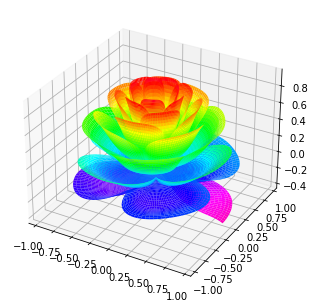

In [53]:
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import cm

from matplotlib.ticker import LinearLocator

import matplotlib.pyplot as plt

import numpy as np

fig=plt.figure()

ax=Axes3D(fig)
#ax = axes3d.Axes3D(fig)

[x,t]=np.meshgrid(np.array(range(25))/24.0,np.arange(0,575.5,0.5)/575*17*np.pi-2*np.pi)

p=(np.pi/2)*np.exp(-t/(8*np.pi))

u=1-(1-np.mod(3.6*t,2*np.pi)/np.pi)**4/2

y=2*(x**2-x)**2*np.sin(p)

r=u*(x*np.sin(p)+y*np.cos(p))

surf=ax.plot_surface(r*np.cos(t),r*np.sin(t),u*(x*np.cos(p)-y*np.sin(p)),rstride=1,cstride=1,cmap=cm.gist_rainbow_r,

                  linewidth=0,antialiased=True)

plt.show()


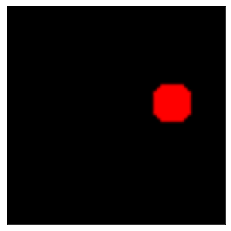

In [54]:
from datasets import *
from models import *
from config import *

node_feat_size = 64
graph_prop_iters = 7
GraphPropagation(num_iters = graph_prop_iters)

grid_convs = RDN(SimpleNamespace(G0=node_feat_size  ,RDNkSize=3,n_colors=3,
                               RDNconfig=(4,3,16),scale=[2],no_upsampling=True))

test_dataset = SpriteData(split = "train")
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = True)

for sample in dataloader:
    ims = sample["image"]
    break;

B, W, H, C = ims.shape
# show the image data to test
plt.figure("input-data", frameon = False,)

for b in range(B):
    plt.subplot(1, B, b + 1);plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False); plt.imshow(ims[b,:,:,:])
plt.show()

In [55]:
imsize = 128
perception_size = 12

# build the connection graph for the grid domain
spatial_edges, spatial_coords = grid(imsize,imsize,device=device)
spaital_edges =  build_perception(imsize,perception_size,device = device)

# flatten the image-feature and add it with the coordinate information
im_feats = grid_convs(ims.permute([0,3,1,2])) # [B,D,W,H]

coords_added_im_feats = im_feats.flatten(2,3).permute(0,2,1) # 【B, N, D】
weights = torch.ones(spatial_edges.shape[1])


graph_in = Batch.from_data_list([Data(x, spatial_edges, edge_attr = {"weights":weights})
                                                for x in coords_added_im_feats])


print(graph_in.x.shape)
print(graph_in.edge_index.shape)
print(graph_in.edge_attr["weights"].shape)


def l2_normalize(x): return torch.nn.functional.normalize(x, p=2.0, dim = -1, eps = 1e-6)

def reduce_max(x, dim, keepdim = True): return torch.max(x, dim = dim, keepdim = keepdim)[0]


torch.Size([16384, 64])
torch.Size([2, 145924])
torch.Size([145924])


In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_planes, planes, norm_fn='group', kernel_size=3, stride=1, residual=True, bias=True, downsample=False):
        super(ResidualBlock, self).__init__()

        padding = 1 if kernel_size == 3 else 0
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, bias=bias, padding=padding, stride=stride)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, bias=bias, padding=padding)
        self.relu = nn.ReLU(inplace=True)

        num_groups = planes // 8

        if norm_fn == 'group':
            self.norm1 = nn.GroupNorm(num_groups=num_groups, num_channels=planes)
            self.norm2 = nn.GroupNorm(num_groups=num_groups, num_channels=planes)
            if not stride == 1 or downsample is True:
                self.norm3 = nn.GroupNorm(num_groups=num_groups, num_channels=planes)

        elif norm_fn == 'batch':
            self.norm1 = nn.BatchNorm2d(planes)
            self.norm2 = nn.BatchNorm2d(planes)
            if not stride == 1 or downsample is True:
                self.norm3 = nn.BatchNorm2d(planes)

        elif norm_fn == 'instance':
            self.norm1 = nn.InstanceNorm2d(planes)
            self.norm2 = nn.InstanceNorm2d(planes)
            if not stride == 1 or downsample is True:
                self.norm3 = nn.InstanceNorm2d(planes)

        elif norm_fn == 'none':
            self.norm1 = nn.Sequential()
            self.norm2 = nn.Sequential()
            if not stride == 1 or downsample is True:
                self.norm3 = nn.Sequential()

        if stride == 1 and not downsample:
            self.shortcut = None

        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=bias), self.norm3)

        self.residual = residual

    def forward(self, x):
        y = x
        y = self.relu(self.norm1(self.conv1(y)))
        y = self.norm2(self.conv2(y))

        if not self.residual:
            return y

        if self.shortcut is not None:
            x = self.shortcut(x)

        return self.relu(x+y)

In [57]:
# [Scene Structure]

def to_base(indices, edges):
    """
    input:
        indices: [K]
        edges: [N,2]
    outputs:
        base_indices: [L]
    """
    base_indices = []
    for i in range(edges.shape[0]): 
        if (edges[i][0] in indices): base_indices.append(i)
    return base_indices

def location_in_node(scene, node):
    return False

class SceneStructure:
    def __init__(self, graph, scores, from_base = None, base = None):
        self.graph = graph
        self.features = graph.x # [N, D]
        self.scores   = scores # [N, 1]
        self.edge_affinities = graph.edge_attr["weights"] #[N, N]
        self.from_base = from_base # [2,N]: [[1, 3],[1, 1]]
        self.base = base # Base Level Scene Structure
    
    def is_base(self): return self.from_base is None

    def locate_in(self, pos, node_indices):return 0

    def compute_masks(self, indices):
         # input: indices of nodes that need to compute mask
         # matrix form version.
        nodes = to_base(indices, self.from_base)
        if self.is_base():return self.scores[nodes]
        return self.base.compute_masks(nodes)

    def sparse_compute_masks(self, indices): 
        # input: indices of nodes that need to compute mask
        nodes = []
        for a in self.from_base.permute([1,0]):
            if a[1] in indices: nodes.append(a[0])
        if self.is_base():
            # this is the base level, just return the corresponding nodes
            return self.scores[nodes]
        return  self.base.compute_masks(nodes)

In [58]:

import numpy as np
import torch
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import pdb, os
import matplotlib.pyplot as plt
from kornia.filters.kernels import (get_spatial_gradient_kernel2d,
                                    normalize_kernel2d)
import time
import sys

def l2_normalize(x):
    return F.normalize(x, p=2.0, dim=-1, eps=1e-6)


def reduce_max(x, dim, keepdim=True):
    return torch.max(x, dim=dim, keepdim=keepdim)[0]


class Competition(nn.Module):

    def __init__(
            self,
            size=None,
            num_masks=16,
            num_competition_rounds=5,
            mask_beta=10.0,
            reduce_func=reduce_max,
            stop_gradient=True,
            stop_gradient_phenotypes=True,
            normalization_func=l2_normalize,
            sum_edges=True,
            mask_thresh=0.5,
            compete_thresh=0.2,
            sticky_winners=True,
            selection_strength=100.0,
            homing_strength=10.0,
            mask_dead_segments=True
    ):
        super().__init__()
        self.num_masks = self.M = num_masks
        self.num_competition_rounds = num_competition_rounds
        self.mask_beta = mask_beta
        self.reduce_func = reduce_func
        self.normalization_func = normalization_func

        ## stop gradients
        self.sg_func = lambda x: (x.detach() if stop_gradient else x)
        self.sg_phenotypes_func = lambda x: (x.detach() if stop_gradient_phenotypes else x)

        ## agent sampling kwargs
        self.sum_edges = sum_edges

        ## competition kwargs
        self.mask_thresh = mask_thresh
        self.compete_thresh = compete_thresh
        self.sticky_winners = sticky_winners
        self.selection_strength = selection_strength
        self.homing_strength = homing_strength
        self.mask_dead_segments = mask_dead_segments

        ## shapes
        self.B = self.T = self.BT = self.N = self.Q = None
        self.size = size  # [H,W]
        if self.size:
            assert len(self.size) == 2, self.size

    def reshape_batch_time(self, x, merge=True):

        if merge:
            self.is_temporal = True
            B, T = x.size()[0:2]
            if self.B:
                assert (B == self.B), (B, self.B)
            else:
                self.B = B

            if self.T:
                assert (T == self.T), (T, self.T)
            else:
                self.T = T

            assert B * T == (self.B * self.T), (B * T, self.B * self.T)
            if self.BT is None:
                self.BT = self.B * self.T

            return torch.reshape(x, [self.BT] + list(x.size())[2:])

        else:  # split
            BT = x.size()[0]
            assert self.B and self.T, (self.B, self.T)
            if self.BT is not None:
                assert BT == self.BT, (BT, self.BT)
            else:
                self.BT = BT

            return torch.reshape(x, [self.B, self.T] + list(x.size())[1:])

    def process_plateau_input(self, plateau):

        shape = plateau.size()
        if len(shape) == 5:
            self.is_temporal = True
            self.B, self.T, self.H, self.W, self.Q = shape
            self.N = self.H * self.W
            self.BT = self.B * self.T
            plateau = self.reshape_batch_time(plateau)
        elif (len(shape) == 4) and (self.size is None):
            self.is_temporal = False
            self.B, self.H, self.W, self.Q = shape
            self.N = self.H * self.W
            self.T = 1
            self.BT = self.B * self.T
        elif (len(shape) == 4) and (self.size is not None):
            self.is_temporal = True
            self.B, self.T, self.N, self.Q = shape
            self.BT = self.B * self.T
            self.H, self.W = self.size
            plateau = self.reshape_batch_time(plateau)
            plateau = torch.reshape(plateau, [self.BT, self.H, self.W, self.Q])
        elif len(shape) == 3:
            assert self.size is not None, \
                "You need to specify an image size to reshape the plateau of shape %s" % shape
            self.is_temporal = False
            self.B, self.N, self.Q = shape
            self.T = 1
            self.BT = self.B
            self.H, self.W = self.size
            plateau = torch.reshape(plateau, [self.BT, self.H, self.W, self.Q])
        else:
            raise ValueError("input plateau map with shape %s cannot be reshaped to [BT, H, W, Q]" % shape)

        return plateau

    def forward(self, plateau):
        """
        Find the uniform regions within the plateau map
        by competition between visual "indices."

        args:
            plateau: [B,[T],H,W,Q] feature map with smooth "plateaus"

        returns:
            masks: [B, [T], H, W, M] <float> one mask in each of M channels
            agents: [B, [T], M, 2] <float> positions of agents in normalized coordinates
            alive: [B, [T], M] <float> binary vector indicating which masks are valid
            phenotypes: [B, [T], M, Q]
            unharvested: [B, [T], H, W] <float> map of regions that weren't covered

        """

        ## preprocess
        plateau = self.process_plateau_input(plateau)  # [BT,H,W,Q]
        plateau = self.normalization_func(plateau)

        ## sample initial indices ("agents") from borders of the plateau map
        agents = sample_coordinates_at_borders(
            plateau.permute(0, 3, 1, 2), num_points=self.M, mask=None, sum_edges=self.sum_edges)

        ## initially all of these agents are "alive"
        alive = torch.ones_like(agents[..., -1:])  # [BT,M,1]

        ## the agents have "phenotypes" depending on where they're situated on the plateau map
        phenotypes = self.sg_phenotypes_func(
            self.normalization_func(soft_index(plateau.permute(0, 3, 1, 2), agents, scale_by_imsize=True)))

        ## the "fitness" of an agent -- how likely it is to survive competition --
        ## is how well its phenotype matches the plateau vector at its current position
        fitnesses = compute_compatibility(agents, plateau, phenotypes, availability=None, noise=0.1)

        ## compute the masks at initialization
        masks_pred = masks_from_phenotypes(plateau, phenotypes, normalize=True)

        ## find the "unharvested" regions of the plateau map not covered by agents
        unharvested = torch.minimum(self.reduce_func(masks_pred, dim=-1, keepdim=True),
                                    torch.tensor(1.0).to(masks_pred))
        unharvested = 1.0 - unharvested.view(self.BT, self.H, self.W, 1)

        for r in range(self.num_competition_rounds):
            # print("Evolution round {}".format(r + 1))

            ## compute the "availability" of the plateau map for each agent (i.e. where it can harvest from)
            alive_t = torch.transpose(alive, 1, 2)  # [BT, 1, M]
            availability = alive_t * masks_pred + (1.0 - alive_t) * unharvested.view(self.BT, self.N, 1)
            availability = availability.view(self.BT, self.H, self.W, self.M)

            ## update the fitnesses
            fitnesses = compute_compatibility(
                positions=agents,
                plateau=plateau,
                phenotypes=phenotypes,
                availability=availability)

            ## kill agents that have wandered off the map
            in_bounds = torch.all(
                torch.logical_and(agents < 1.0, agents > -1.0),
                dim=-1, keepdim=True)  # [BT,M,1]
            fitnesses *= in_bounds.to(fitnesses)

            ## break ties in fitness
            fitnesses -= 0.001 * torch.arange(self.M, dtype=torch.float32)[None, :, None].expand(self.BT, -1, -1).to(
                fitnesses)

            ## recompute the masks
            occupied_regions = self.sg_phenotypes_func(
                soft_index(plateau.permute(0, 3, 1, 2), agents, scale_by_imsize=True))
            masks_pred = masks_from_phenotypes(plateau, occupied_regions, normalize=True)  # [BT,N,M]

            ## have each pair of agents compete.
            ## If their masks overlap, the winner is the one with higher fitness
            alive = compete_agents(masks_pred, fitnesses, alive,
                                   mask_thresh=self.mask_thresh,
                                   compete_thresh=self.compete_thresh,
                                   sticky_winners=self.sticky_winners)

            alive *= in_bounds.to(alive)
            alive_t = torch.transpose(alive, 1, 2)

            # print("Num alive masks", alive.sum())

            ## update which parts of the plateau are "unharvested"
            unharvested = torch.minimum(self.reduce_func(masks_pred * alive_t, dim=-1, keepdim=True),
                                        torch.tensor(1.0, dtype=torch.float32).to(masks_pred))
            unharvested = 1.0 - unharvested.view(self.BT, self.H, self.W, 1)

            ## update phenotypes of the winners
            if self.mask_thresh is not None:
                winner_phenotypes = (masks_pred[..., None] > self.mask_thresh).to(plateau)
            winner_phenotypes = winner_phenotypes * plateau.view(self.BT, self.N, 1, self.Q)
            winner_phenotypes = self.normalization_func(winner_phenotypes.mean(dim=1))  # [BT,M,Q]
            phenotypes += (alive * winner_phenotypes) * self.selection_strength

            ## reinitialize losing agent positions
            alive_mask = (alive > 0.5).to(torch.float32)
            loser_agents = sample_coordinates_at_borders(
                plateau.permute(0, 3, 1, 2), num_points=self.M,
                mask=unharvested.permute(0, 3, 1, 2),
                sum_edges=self.sum_edges)
            agents = agents * alive_mask + loser_agents * (1.0 - alive_mask)

            ## reinitialize loser agent phenotypes
            loser_phenotypes = self.normalization_func(
                compute_distance_weighted_vectors(plateau, agents, mask=unharvested, beta=self.homing_strength))
            phenotypes = alive_mask * phenotypes + (1.0 - alive_mask) * loser_phenotypes
            phenotypes = self.normalization_func(phenotypes)

        ## run a final competition between the surviving masks
        if self.mask_beta is not None:
            masks_pred = F.softmax(
                self.mask_beta * masks_pred * alive_t - \
                self.mask_beta * (1.0 - alive_t), dim=-1)
        if self.mask_dead_segments:
            masks_pred *= alive_t

        masks_pred = masks_pred.view(self.BT, self.H, self.W, self.M)
        if self.is_temporal:
            masks_pred = self.reshape_batch_time(plateau, merge=False)
            agents = self.reshape_batch_time(agents, merge=False)
            alive = self.reshape_batch_time(alive, merge=False)
            phenotype = self.reshape_batch_time(phenotype, merge=False)
            unharvested = self.reshape_batch_time(unharvested, merge=False)

        return (masks_pred, agents, alive, phenotypes, unharvested)



def coordinate_ims(batch_size, seq_length, imsize):
    static = False
    if seq_length == 0:
        static = True
        seq_length = 1
    B = batch_size
    T = seq_length
    H, W = imsize
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    ones = torch.ones([B, H, W, 1], dtype=torch.float32).to(device)
    h = torch.divide(torch.arange(H).to(ones), torch.tensor(H - 1, dtype=torch.float32).to(ones))
    h = 2.0 * ((h.view(1, H, 1, 1) * ones) - 0.5)
    w = torch.divide(torch.arange(W).to(ones), torch.tensor(W - 1, dtype=torch.float32).to(ones))
    w = 2.0 * ((w.view(1, 1, W, 1) * ones) - 0.5)
    h = torch.stack([h] * T, 1)
    w = torch.stack([w] * T, 1)
    hw_ims = torch.cat([h, w], -1)
    if static:
        hw_ims = hw_ims[:, 0]
    return hw_ims


def dot_product_attention(queries, keys, normalize=True, eps=1e-8):
    """
    Compute the normalized dot product between two PyTorch tensors
    """
    B, N, D_q = queries.size()
    _B, N_k, D_k = keys.size()
    assert D_q == D_k, (queries.shape, keys.shape)
    if normalize:
        queries = F.normalize(queries, p=2.0, dim=-1, eps=eps)
        keys = F.normalize(keys, p=2.0, dim=-1, eps=eps)

    outputs = torch.matmul(queries, torch.transpose(keys, 1, 2))  # [B, N, N_k]
    attention = torch.transpose(outputs, 1, 2)  # [B, N_k, N]

    return outputs


def sample_image_inds_from_probs(probs, num_points, eps=1e-8):
    B, H, W = probs.shape
    P = num_points
    N = H * W

    probs = probs.reshape(B, N)

    probs = torch.maximum(probs + eps, torch.tensor(0.).to(probs)) / (probs.sum(dim=-1, keepdim=True) + eps)
    dist = Categorical(probs=probs)
    indices = dist.sample([P]).permute(1, 0).to(torch.int32)  # [B,P]

    # indices_h = torch.minimum(torch.maximum(torch.div(indices, W, rounding_mode='floor'), torch.tensor(0)), torch.tensor(H-1))
    indices_h = torch.minimum(torch.maximum(torch.div(indices, W, rounding_mode='floor'), torch.tensor(0).to(indices)), torch.tensor(H - 1).to(indices))
    indices_w = torch.minimum(torch.maximum(torch.fmod(indices, W), torch.tensor(0).to(indices)), torch.tensor(W - 1).to(indices))
    indices = torch.stack([indices_h, indices_w], dim=-1)  # [B,P,2]
    return indices


def get_gradient_image(image, mode='sobel', order=1, normalize_kernel=True):
    B, C, H, W = list(image.size())

    # prepare kernel
    kernel = get_spatial_gradient_kernel2d(mode, order)
    if normalize_kernel:
        kernel = normalize_kernel2d(kernel)
    tmp_kernel = kernel.to(image).detach()
    tmp_kernel = tmp_kernel.unsqueeze(1).unsqueeze(1)
    kernel_flip = tmp_kernel.flip(-3)

    # pad spatial dims of image
    padding = [kernel.size(1) // 2, kernel.size(1) // 2, kernel.size(2) // 2, kernel.size(2) // 2]
    out_channels = 3 if (order == 2) else 2
    padded_image = F.pad(image.reshape(B * C, 1, H, W), padding, 'replicate')[:, :, None]  # [B*C,1,1,H+p,W+p]
    gradient_image = F.conv3d(padded_image, kernel_flip, padding=0).view(B, C, out_channels, H, W)
    return gradient_image


def sample_coordinates_at_borders(image, num_points=16, mask=None, sum_edges=True, normalized_coordinates=True):
    """
    Sample num_points in normalized (h,w) coordinates from the borders of the input image
    """
    B, C, H, W = list(image.size())
    if mask is not None:
        assert mask.shape[2:] == image.shape[2:], (mask.size(), image.size())
    else:
        mask = torch.ones(size=(B, 1, H, W)).to(image)

    gradient_image = get_gradient_image(image * mask, mode='sobel', order=1)  # [B,C,2,H,W]
    gradient_magnitude = torch.sqrt(torch.square(gradient_image).sum(dim=2))
    if sum_edges:
        edges = gradient_magnitude.sum(1)  # [B,H,W]
    else:
        edges = gradient_magnitude.max(1)[0]

    if mask is not None:
        edges = edges * mask[:, 0]

    coordinates = sample_image_inds_from_probs(edges, num_points=num_points)
    if normalized_coordinates:
        coordinates = coordinates.float()
        coordinates /= torch.tensor([H - 1, W - 1], dtype=torch.float32).to(coordinates)[None, None]
        coordinates = 2.0 * coordinates - 1.0
    return coordinates


def index_into_images(images, indices, channels_last=False):
    """
    index into an image at P points to get its values
    
    images: [B,C,H,W]
    indices: [B,P,2] 
    """
    assert indices.size(-1) == 2, indices.size()
    if channels_last:
        images = images.permute(0, 3, 1, 2)  # [B,C,H,W]
    B, C, H, W = images.shape
    _, P, _ = indices.shape
    inds_h, inds_w = list(indices.to(torch.long).permute(2, 0, 1))  # [B,P] each
    inds_b = torch.arange(B, dtype=torch.long).unsqueeze(-1).expand(-1, P).to(inds_h)
    inds = torch.stack([inds_b, inds_h, inds_w], 0)
    values = images.permute(0, 2, 3, 1)[list(inds)]  # [B,P,C]
    return values


def soft_index(images, indices, scale_by_imsize=True):
    assert indices.shape[-1] == 2, indices.shape
    B, C, H, W = images.shape
    _, P, _ = indices.shape

    # h_inds, w_inds = indices.split([1,1], dim=-1)
    h_inds, w_inds = list(indices.permute(2, 0, 1))
    if scale_by_imsize:
        h_inds = (h_inds + 1.0) * torch.tensor(H).to(h_inds) * 0.5
        w_inds = (w_inds + 1.0) * torch.tensor(W).to(w_inds) * 0.5

    h_inds = torch.maximum(torch.minimum(h_inds, torch.tensor(H - 1).to(h_inds)), torch.tensor(0.).to(h_inds))
    w_inds = torch.maximum(torch.minimum(w_inds, torch.tensor(W - 1).to(w_inds)), torch.tensor(0.).to(w_inds))

    h_floor = torch.floor(h_inds)
    w_floor = torch.floor(w_inds)
    h_ceil = torch.ceil(h_inds)
    w_ceil = torch.ceil(w_inds)

    bot_right_weight = (h_inds - h_floor) * (w_inds - w_floor)
    bot_left_weight = (h_inds - h_floor) * (w_ceil - w_inds)
    top_right_weight = (h_ceil - h_inds) * (w_inds - w_floor)
    top_left_weight = (h_ceil - h_inds) * (w_ceil - w_inds)

    in_bounds = (bot_right_weight + bot_left_weight + top_right_weight + top_left_weight) > 0.95
    in_bounds = in_bounds.to(torch.float32)

    top_left_vals = index_into_images(images, torch.stack([h_floor, w_floor], -1))
    top_right_vals = index_into_images(images, torch.stack([h_floor, w_ceil], -1))
    bot_left_vals = index_into_images(images, torch.stack([h_ceil, w_floor], -1))
    bot_right_vals = index_into_images(images, torch.stack([h_ceil, w_ceil], -1))

    im_vals = top_left_vals * top_left_weight[..., None]
    im_vals += top_right_vals * top_right_weight[..., None]
    im_vals += bot_left_vals * bot_left_weight[..., None]
    im_vals += bot_right_vals * bot_right_weight[..., None]

    im_vals = im_vals.view(B, P, C)

    return im_vals


def compute_compatibility(positions, plateau, phenotypes=None, availability=None, noise=0.1):
    """
    Compute how well "fit" each agent is for the position it's at on the plateau,
    according to its "phenotype"

    positions: [B,P,2]
    plateau: [B,H,W,Q]
    phenotypes: [B,P,D] or None
    availability: [B,H,W,A]
    """
    B, H, W, Q = plateau.shape
    P = positions.shape[1]
    if phenotypes is None:
        raise ValueError  # TODO: check the correctness of the line below
        phenotypes = soft_index(plateau, positions)

    if availability is not None:
        assert list(availability.shape)[:-1] == list(plateau.shape)[:-1], (availability.shape, plateau.shape)
        A = availability.size(-1)
        assert P % A == 0, (P, A)
        S = P // A  # population size
        plateau = availability[..., None] * plateau[..., None, :]  # [B,H,W,A,Q]
        plateau = plateau.view(B, H, W, A * Q)

    plateau_values = soft_index(plateau.permute(0, 3, 1, 2), positions, scale_by_imsize=True)
    if noise > 0:
        plateau_values += noise * torch.rand(size=plateau_values.size(), dtype=torch.float32).to(plateau_values)

    if availability is not None:
        plateau_values = l2_normalize(plateau_values.view(B, P, A, Q))
        # inds = torch.tile(torch.eye(A)[None].expand(B,-1,-1), (1,S,1))[...,None] # [B,P,A,1]
        inds = (torch.eye(A)[None].expand(B, -1, -1)).repeat(1, S, 1)[..., None]  # [B,P,A,1]
        plateau_values = torch.sum(plateau_values * inds.to(plateau_values), dim=-2)  # [B,P,Q]
    else:
        plateau_values = l2_normalize(plateau_values)

    compatibility = torch.sum(
        l2_normalize(phenotypes) * plateau_values, dim=-1, keepdim=True)  # [B,P,1]

    return compatibility


def compute_pairwise_overlaps(masks, masks_target=None, mask_thresh=None, eps=1e-6):
    """Find overlaps between masks"""
    B, N, P = masks.shape
    if masks_target is None:
        masks_target = masks
    if mask_thresh is not None:
        masks = (masks > mask_thresh).to(torch.float32)
        masks_target = (masks_target > mask_thresh).to(torch.float32)

    ## union and intersection
    overlaps = masks[..., None] * masks_target[..., None, :]  # [B,N,P,P]
    I = overlaps.sum(dim=1)
    U = torch.maximum(masks[..., None], masks_target[..., None, :]).sum(dim=1)
    iou = I / torch.maximum(U, torch.tensor(eps, dtype=torch.float32).to(masks))  # [B,P,P]

    return iou


def compete_agents(masks, fitnesses, alive,
                   mask_thresh=0.5, compete_thresh=0.2,
                   sticky_winners=True):
    """
    Kill off agents (which mask dimensions are "alive") based on mask overlap and fitnesses of each

    args:
        masks: [B,N,P]
        fitnesses: [B,P,1]
        alive: [B,P,1]

    returns:
        still_alive: [B,P,1]
    
    """
    B, N, P = masks.shape
    assert list(alive.shape) == [B, P, 1], alive.shape
    assert list(fitnesses.shape) == [B, P, 1], fitnesses.shape

    ## find territorial disputes
    overlaps = compute_pairwise_overlaps(masks, masks_target=None, mask_thresh=mask_thresh)
    disputes = overlaps > compete_thresh  # [B,P,P] <bool>

    ## agents don't fight themselves
    disputes = torch.logical_and(
        disputes, torch.logical_not(
            torch.eye(P, dtype=torch.bool).to(disputes).unsqueeze(0).expand(B, -1, -1)))

    ## kill off the agents with lower fitness in each dispute
    killed = torch.logical_and(disputes, fitnesses < torch.transpose(fitnesses, 1, 2))

    ## once an agent wins, it always wins again
    if sticky_winners:
        winners = (alive > 0.5)
        losers = torch.logical_not(winners)

        ## winners can't lose to last round's losers
        winners_vs_losers = torch.logical_and(winners, torch.transpose(losers, 1, 2))  # [B,P,P]
        killed = torch.logical_and(killed, torch.logical_not(winners_vs_losers))

        ## losers can't overtake last round's winners
        losers_vs_winners = torch.logical_and(losers, torch.transpose(winners, 1, 2))
        losers_vs_winners_disputes = torch.logical_and(losers_vs_winners, disputes)
        killed = torch.logical_or(killed, losers_vs_winners_disputes)

    ## if an agent was killed by *any* competitor, it's dead
    killed = torch.any(killed, dim=2, keepdim=True)
    alive = torch.logical_not(killed).to(torch.float32)

    return alive


def compute_distance_weighted_vectors(vector_map, positions, mask=None, beta=1.0, eps=1e-8):
    """
    compute vectors whose values are a weighted mean of vector_map, where weights are given by distance.
    """
    B, H, W, D = vector_map.shape
    assert positions.size(-1) == 2, positions.size()
    B, P, _ = positions.shape
    N = H * W

    if mask is None:
        mask = torch.ones_like(vector_map[..., 0:1])
    else:
        assert list(mask.shape) == [B, H, W, 1]

    hw_grid = coordinate_ims(B, 0, [H, W]).view(B, N, 2)
    delta_positions = hw_grid[:, None] - positions[:, :, None]  # [B,P,N,2]
    distances = torch.sqrt(delta_positions[..., 0] ** 2 + delta_positions[..., 1] ** 2 + eps)  # [B,P,N]

    ## max distance is 2*sqrt(2)
    inv_distances = (2.0 * np.sqrt(2.0)) / (distances + eps)
    inv_distances = F.softmax(beta * inv_distances * mask.view(B, 1, N), dim=-1)  # [B,P,N]
    distance_weighted_vectors = torch.sum(
        vector_map.view(B, 1, N, D) * inv_distances[..., None], dim=2, keepdim=False)  # [B,P,D]
    return distance_weighted_vectors


def masks_from_phenotypes(plateau, phenotypes, normalize=True):
    B, H, W, Q = plateau.shape
    N = H * W
    masks = dot_product_attention(
        queries=plateau.view(B, N, Q),
        keys=phenotypes,
        normalize=normalize)
    masks = F.relu(masks)
    return masks




def object_id_hash(objects, dtype_out=torch.int32, val=256, channels_last=False):
    '''
    objects: [...,C]
    val: a number castable to dtype_out

    returns:
    out: [...,1] where each value is given by sum([val**(C-1-c) * objects[...,c:c+1] for c in range(C)])
    '''
    if not isinstance(objects, torch.Tensor):
        objects = torch.tensor(objects)
    if not channels_last:
        objects = objects.permute(0, 2, 3, 1)
    C = objects.shape[-1]
    val = torch.tensor(val, dtype=dtype_out)
    objects = objects.to(dtype_out)
    out = torch.zeros_like(objects[..., 0:1])
    for c in range(C):
        scale = torch.pow(val, C - 1 - c)
        out += scale * objects[..., c:c + 1]
    if not channels_last:
        out = out.permute(0, 3, 1, 2)

    return out


def segments_rgb_to_one_hot(objects, channels_last=False, max_objects=8):
    hashed_objects = object_id_hash(objects, channels_last=channels_last)
    if channels_last:
        hashed_objects = hashed_objects.permute(0, 3, 1,
                                                2)  # [B,1,H,W]
    hashed_objects = list(hashed_objects[:,
                          0])  # B-length list of [H,W]
    out = []
    for b, im in enumerate(hashed_objects):
        one_hot_im = []
        obj_ids = torch.unique(im).to(im)
        for o_id in list(obj_ids[:max_objects]):
            obj = (im == o_id)
            one_hot_im.append(obj)
        one_hot_im = torch.stack(one_hot_im, 0).to(torch.float32)
        pad = torch.zeros(size=([max_objects - int(one_hot_im.shape[0])] + list(one_hot_im.shape)[1:])).to(one_hot_im)
        one_hot_im = torch.cat([one_hot_im, pad], 0)
        print(one_hot_im.shape)
        out.append(one_hot_im)
    out = torch.stack(out, 0)
    return out

In [59]:
# may be we need a new graph propagation module

class GraphPropagator(nn.Module):
    def __init__(self, num_iters = 10, excite = True, inhibit = True, project = False, adj_thresh = 0.5):
        super().__init__()
        self.num_iters = num_iters
        self.excite = excite
        self.inhibit = inhibit
        self.project = project
        self.adj_thresh = adj_thresh
    
    @staticmethod
    def _threshold(x, thresh):
        return x * (x > thresh).float()

    @staticmethod
    def _threshold_sparse_tensor(x, thresh):
        row, col, value = x.coo()
        valid = value > thresh
        sparse_size = [x.size(0), x.size(1)]
        output = SparseTensor(row=row[valid],col=col[valid],value=value[valid],sparse_sizes=sparse_size)
        return output

    @staticmethod
    def _projection(v, u, eps=1e-12):
        u_norm = torch.sum(u * u, -1, keepdims=True)
        dot_prod = torch.sum(v * u, -1, keepdims=True)
        proj = (dot_prod / (u_norm + eps)) * u
        return proj

    @staticmethod
    def _relu_norm(x, relu=True, norm=True, eps=1e-16):
        x = F.relu(x) if relu else x
        x = F.normalize(x + eps, p=2.0, dim=-1, eps=max([eps, 1e-12])) if norm else x
        return x

    def excitory(self, weights, thresh = 0.5):
        return weights * (weights >= thresh)
    def inhibitory(self, weights, thresh = 0.5):
        return weights * (weights < thresh)

    def forward(self, state, edge_index, weights):
        state = self._relu_norm(state)
        weights = weights.unsqueeze(-1)
        for _ in range(9):
            state[edge_index[1,:],:] += self.excitory(weights, thresh = 0.5) * state[edge_index[0,:],:]
            state[edge_index[1,:],:] -= self.inhibitory(weights, thresh = 0.5) * state[edge_index[0,:],:]
            state = self._relu_norm(state)
        return state

    def propagate_step(self, state, h_e, h_i):
        return 0

class GraphPropagator(nn.Module):
    def __init__(self,
                 num_iters=15,
                 excite=True,
                 inhibit=True,
                 project=False,
                 adj_thresh=0.7):
        super().__init__()
        self.num_iters = num_iters
        self.excite = excite
        self.inhibit = inhibit
        self.project = project
        self.adj_thresh = adj_thresh

        self.adj_e = None
        self.adj_i = None
        self.norm_factor_e = None
        self.norm_factor_i = None
        self.activation_converge = False

    def preprocess_inputs(self, h0, adj, activated):
        B, N, K = h0.shape

        # activated: binary tensor indicating nodes to start propagation from
        if activated is None: # randomly initialized at a point
            rand_idx = torch.randint(0, N, [B, ]).to(h0.device)
            activated = F.one_hot(rand_idx, num_classes=N).unsqueeze(-1).float()  # [BT, N, 1]
        else:
            activated = activated.reshape(B, N, 1)

        # create excitatory and inhibitory affinities, followed by thresholding
        if not isinstance(adj, SparseTensor): # dense tensor
            adj = adj.reshape(B, N, N)
            adj_e, adj_i = adj, 1.0 - adj
            if self.adj_thresh is not None:
                adj_e = self._threshold(adj_e, self.adj_thresh)
                adj_i = self._threshold(adj_i, self.adj_thresh)
            sample_mask = None
        else: # sparse tensor
            adj_e = adj
            adj_i = adj.copy().set_value_(1.0 - adj.storage.value())

            sample_mask = adj_e.copy()
            sample_mask = sample_mask.set_value_(torch.ones_like(sample_mask.storage.value()))

            if self.adj_thresh is not None:
                adj_e = self._threshold_sparse_tensor(adj_e, self.adj_thresh)
                adj_i = self._threshold_sparse_tensor(adj_i, self.adj_thresh)

        return h0, adj_e, adj_i, activated, sample_mask
    def forward(self, h0, adj, activated=None):
        """
        Function: Graph propagation to create the plateau map representation
        Input:
        - h0: initial hidden states (or equivalently, plateau map representation) with shape [B, N Q]
        - adj: affinity matrix with shape
        - activated: The graph propagation will start from the activated nodes
                   It can be None or binary tensor of shape [B, N].
                   If None, one node will be randomly selected as being activated
        Return:
        - plateau_map_list: a list of plateau maps of len self.num_iters. Each plateau map has shape [B, N, Q]
        """

        h0, adj_e, adj_i, activated, sample_mask = self.preprocess_inputs(h0, adj, activated)

        h = h0.clone()
        plateau_map_list = []
        running_activated = activated
        self.activation_converge = False

        # start graph propagation
        for it in range(self.num_iters):
            h, activated, running_activated = \
                self.propagate(h, adj_e, adj_i, activated, running_activated, sample_mask, it)
            plateau_map_list.append(h.reshape(h0.shape))

        return plateau_map_list[-1]

    def propagate(self, h, adj_e, adj_i, activated, running_activated, sample_mask, iter):
        B, N, D = h.shape

        # Graph propagation starts at a subset of activated nodes
        # If self.activation_converge is False, i.e. not all nodes are activated, \
        #   we need to apply masking to the affinities and compute the normalization factor accordingly.
        # We do so until all the nodes are activated, i.e.  self.activation_converge == True

        if not self.activation_converge:
            if isinstance(adj_e, SparseTensor):
                # apply the activation mask on the affinity tensors
                adj_e = adj_e.mul(activated.flatten()[None])
                adj_i = adj_i.mul(activated.flatten()[None])
                sample_mask = sample_mask.mul(activated.flatten()[None])

            # compute the normalization factors
            if not isinstance(adj_e, SparseTensor):
                norm_factor_e = torch.sum(adj_e.abs() * activated, dim=-2, keepdim=True).clamp(min=1.0).detach()
                norm_factor_i = torch.sum(adj_i.abs() * activated, dim=-2, keepdim=True).clamp(min=1.0).detach()
            else:
                norm_factor_e = adj_e.sum(1).reshape(B, N, 1).clamp(min=1.0).detach()
                norm_factor_i = adj_i.sum(1).reshape(B, N, 1).clamp(min=1.0).detach()

            self.norm_factor_e = norm_factor_e # [B,1,N]
            self.norm_factor_i = norm_factor_i # [B,1,N]
            self.adj_e = adj_e
            self.adj_i = adj_i

            self.activation_converge = activated.sum() == (B * N)
        else: # no update is required if all the nodes are activated
            adj_e = self.adj_e
            adj_i = self.adj_i
            norm_factor_e = self.norm_factor_e
            norm_factor_i = self.norm_factor_i
            sample_mask = None

        # [Excitation]
        if self.excite:
            if not isinstance(adj_e, SparseTensor):
                e_effects = torch.matmul(h.permute(0, 2, 1), adj_e * activated) / norm_factor_e
                e_effects = e_effects.permute(0, 2, 1)
            else:
                e_effects = adj_e.matmul(h.reshape(B * N, D))
                e_effects = e_effects.reshape(B, N, D) / norm_factor_e
            h = h + e_effects

        # [Inhibition]
        if self.inhibit:
            if not isinstance(adj_e, SparseTensor):
                i_effects = torch.matmul(h.permute(0, 2, 1), adj_i * activated) / norm_factor_i
                i_effects = i_effects.permute(0, 2, 1)
            else:
                i_effects = adj_i.matmul(h.reshape(B * N, D))
                i_effects = i_effects.reshape(B, N, D) / norm_factor_i

            proj = self._projection(h, i_effects) if self.project else i_effects
            h = h - proj

        h = self._relu_norm(h)

        # [Update activated nodes]
        if activated.sum() < B * N:
            if not isinstance(adj_e, SparseTensor):
                receivers = torch.max(torch.where(adj_e > adj_i, adj_e, adj_i) * activated, dim=1, keepdim=False)[0] > 0.5 # [B,N]
            else:
                assert sample_mask is not None
                receivers = sample_mask.max(dim=1) > 0.5
                receivers = receivers.reshape(B, N)

            running_activated = running_activated + receivers.unsqueeze(-1).float()
            activated = running_activated.clamp(max=1.0).detach()

        return h, activated, running_activated

    @staticmethod
    def _threshold(x, thresh):
        return x * (x > thresh).float()

    @staticmethod
    def _threshold_sparse_tensor(x, thresh):
        row, col, value = x.coo()
        valid = value > thresh
        sparse_size = [x.size(0), x.size(1)]
        output = SparseTensor(row=row[valid],col=col[valid],value=value[valid],sparse_sizes=sparse_size)
        return output

    @staticmethod
    def _projection(v, u, eps=1e-12):
        u_norm = torch.sum(u * u, -1, keepdims=True)
        dot_prod = torch.sum(v * u, -1, keepdims=True)
        proj = (dot_prod / (u_norm + eps)) * u
        return proj

    @staticmethod
    def _relu_norm(x, relu=True, norm=True, eps=1e-16):
        x = F.relu(x) if relu else x
        x = F.normalize(x + eps, p=2.0, dim=-1, eps=max([eps, 1e-12])) if norm else x
        return x

In [60]:
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [61]:
# write some util functions

import numpy as np

def sample_indices(batch, size, k_samples):
    max_index = size;sample_index = []
    for b in range(batch):
        in_batch_index = []
        for k in range(k_samples): 
            in_batch_index.append(np.random.randint(0, max_index))
        sample_index.append(torch.tensor(in_batch_index).unsqueeze(0).long())
    sample_index = torch.cat(sample_index, dim = 0)
    return sample_index

def uniform_fully_connected(batch_size = 3, size = 30):
    assert size % batch_size == 0, print("full size cannot be batchify")
    full_edges = []
    for b in range(batch_size):
        for i in range(size // batch_size):
            for j in range(size // batch_size):full_edges.append([b * i,b * j])
    full_edges = torch.tensor(full_edges).t()
    return full_edges

# [Node Extraction]

class NodeExtraction(nn.Module):
    def __init__(self, k_nodes = 5, grid_size = 128*128):
        super().__init__()
        self.k_nodes = k_nodes
        self.grid_size = grid_size

    def forward(self,state):
        """
        input: scene structure with
            x: node features [N, D]
            from_base: connection to the lower level
            locate_in(loc, node) -> bool
        output: at most k nodes from the 
        """
        node_features = state #[N,D]
        B = state.shape[0]

        sample_index = sample_indices(B, size = self.grid_size, k_samples = self.k_nodes)
        #print(sample_index.shape, node_features.shape)
        sample_features = torch.cat([ node_features[b:b+1,sample_index[b,:],:] for b in range(B)], dim = 0)

        #masks = torch.sigmoid((torch.matmul(sample_features, node_features.permute(1,0)) - 0.2) / 0.02 )
        vals = torch.einsum("bmc,bnc->bmn",sample_features, node_features)
        print(vals.max(), vals.min())
        masks = torch.softmax( (torch.einsum("bmc,bnc->bmn",sample_features, node_features) - 0.0)/0.02 , dim = 1) 

        return masks

if 1:
    print("test utility of the node extraction")
    indices = sample_indices(3, 2*2, 4)
    print(indices)

test utility of the node extraction
tensor([[2, 3, 0, 3],
        [2, 0, 0, 1],
        [0, 1, 0, 2]])


In [62]:
def local_to_sparse_global_affinity(local_adj, sample_inds, activated=None, sparse_transpose=False):
    """
    Convert local adjacency matrix of shape [B, N, K] to [B, N, N]
    :param local_adj: [B, N, K]
    :param size: [H, W], with H * W = N
    :return: global_adj [B, N, N]
    """

    B, N, K = list(local_adj.shape)

    if sample_inds is None:
        return local_adj

    assert sample_inds.shape[0] == 3
    local_node_inds = sample_inds[2] # [B, N, K]

    batch_inds = torch.arange(B).reshape([B, 1]).to(local_node_inds)
    node_inds = torch.arange(N).reshape([1, N]).to(local_node_inds)
    row_inds = (batch_inds * N + node_inds).reshape(B * N, 1).expand(-1, K).flatten()  # [BNK]

    col_inds = local_node_inds.flatten()  # [BNK]
    valid = col_inds < N

    col_offset = (batch_inds * N).reshape(B, 1, 1).expand(-1, N, -1).expand(-1, -1, K).flatten() # [BNK]
    col_inds += col_offset
    value = local_adj.flatten()

    if activated is not None:
        activated = activated.reshape(B, N, 1).expand(-1, -1, K).bool()
        valid = torch.logical_and(valid, activated.flatten())

    if sparse_transpose:
        global_adj = SparseTensor(row=col_inds[valid], col=row_inds[valid],
                                  value=value[valid], sparse_sizes=[B*N, B*N])
    else:
        raise ValueError('Current KP implementation assumes tranposed affinities')

    return global_adj

#print(torch.cosine_similarity(v1, v2, dim = 0))

In [165]:

# prototype for the construct quarter
class ConstructQuarter(nn.Module):
    def __init__(self, in_feat_size, out_feat_size, k_nodes = 5, grid_size = 128 * 128):
        super().__init__()
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        # [Graph Convolution] for the input data
        self.graph_conv = GCNConv(in_feat_size, out_feat_size)
        self.location_itrs = k_nodes

        # [Affinity Decoder] softversion of graph constructer
        self.k_conv = GCNConv(in_feat_size, out_feat_size)
        self.q_conv = GCNConv(in_feat_size, out_feat_size)

        # [Graph Propagation] create the Graph Propgation Module
        self.graph_propagator = GraphPropagator(num_iters = 55,project=False,adj_thresh = 0.5)
        # GraphPropagator(num_iters = 7)

        # [Node Extraction]
        self.node_extractor = Competition(num_masks = k_nodes - 1)
        #NodeExtraction(k_nodes = k_nodes, grid_size = grid_size)
        
    def forward(self, node_features, node_edges = None, node_weights = None):
        # abstract the input graph data
        B,N,D = node_features.shape
        if node_edges is None:
            # need an extra step to build edges and decode affinities
            # [Abstract]
            edge_index = uniform_fully_connected(B, size = B)
            abstract_features = self.graph_conv(x, edge_index)

            # [Constructe Affinities]
            decode_ks = self.k_conv(x, edge_index)
            decode_qs = self.q_conv(x, edge_index)
            # build affinities
            weights = torch.cosine_similarity(decode_ks[:,edges[0,:],:] , decode_qs[:,edges[1,:],:], dim =-1)
            edge_weights = softmax_max_norm(weights)

        # After this stage, {edge_index} ,{edge_weights} should be available
        # torch.Size([3, 16384, 64]) torch.Size([3, 2, 434724]) torch.Size([3, 434724])

        # [Propagate]
        # perform propagation over the continuous label on the graph 
        sparse_size = (B*N, B*N)
        Q = 64
        random_init_state = torch.randn([B,N,Q]) # random initialize labels : [B,N,D]
        # [B,N,D]   [B,2,n']    [B,n']
        rows = []; cols = []; ws = [];
        for b in range(B):rows.append(node_edges[b,0,:].long());cols.append(node_edges[b,1,:].long());ws.append(node_weights[b,:])
        rows = torch.cat(rows, dim = -1); cols = torch.cat(cols, dim = -1); ws = torch.cat(ws, dim = -1)
        adjs = SparseTensor(row=rows,\
                            col=cols,\
                            value=ws,
                            sparse_sizes=sparse_size)
        prop_features = self.graph_propagator(random_init_state, adjs) # [B,N,Q]
        W,H = 128,128
        platmap = prop_features.reshape([B,W,H,Q])
        
        # [Extract Nodes]
        # region competition and constuct the nodes at each level.
        masks_extracted, agents, alive, pheno, unharv = self.node_extractor(platmap)
        masks_extracted = torch.cat([masks_extracted, unharv], dim = -1).permute([0,3,1,2])
        #masks_extracted = self.node_extractor(prop_features)
        # B,M,N #["batch_node_masks"], node_outputs["batch_index"], node_outputs["sample_index"]
        B,N,_,_ = masks_extracted.shape
        node_features = torch.einsum("bnd,bmn->bmd",node_features, masks_extracted.reshape([B,N,W*H]))
        node_features = F.normalize(node_features, p=2, dim=1, eps=1e-12, out=None)

        node_scores = torch.max(masks_extracted, dim = -1).values
        node_masks = masks_extracted 

        # node_features, node_masks, node_scores
        return node_features, node_masks, node_scores

In [173]:
import math

def softmax_max_norm(x):
    x = x.softmax(-1)
    x = x / torch.max(x, dim=-1, keepdim=True)[0].clamp(min=1e-12)# .detach()
    return x
    
class ConstructNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        device = config.device
        # construct the grid domain connection
        self.imsize = config.imsize
        self.perception_size = 7#config.perception_size
        # build the connection graph for the grid domain
        spatial_edges, self.spatial_coords = grid(self.imsize,self.imsize,device=device)
        self.spatial_edges =  build_perception(self.imsize,self.perception_size,device = device)
    
        node_feat_size = 64#config.node_feat_dim
        # [Grid Convolution]
        self.grid_convs =RDN(SimpleNamespace(G0=node_feat_size  ,RDNkSize=3,n_colors=3,RDNconfig=(4,3,16),scale=[2],no_upsampling=True))
        
        # [Affinity Decoder]
        kq_dim = node_feat_size
        latent_dim = node_feat_size
        norm_fn = "batch"
        kernel_size = 3
        downsample = False
        self.k_convs = nn.Sequential(
            ResidualBlock(kq_dim, latent_dim, norm_fn, kernel_size=kernel_size, bias=False, stride=1, residual=True, downsample=downsample),
            nn.Conv2d(latent_dim, kq_dim, kernel_size=1, bias=True, padding='same'))
        self.q_convs = nn.Sequential(
            ResidualBlock(kq_dim, latent_dim, norm_fn, kernel_size=kernel_size, bias=False, stride=1, residual=True, downsample=downsample),
            nn.Conv2d(latent_dim, kq_dim, kernel_size=1, bias=True, padding='same'))

        # [Construct Quarters]
        construct_config = (128*128,10)
        self.construct_quarters = nn.ModuleList(
            [ConstructQuarter(node_feat_size, node_feat_size, construct_config[i+1], construct_config[i]) for i in range(len(construct_config) - 1)]
        )

        self.verbose = 0

    def forward(self, ims):
        # flatten the image-feature and add it with the coordinate information
        B, W, H, C = ims.shape
        im_feats = self.grid_convs(ims.permute([0,3,1,2])) # [B,D,W,H]

        # [Image Grid Convolution]
        coords_added_im_feats = im_feats.flatten(2,3).permute(0,2,1); # 【B, N, D】


        # [Affinity Decoder](base)
        edges = self.spatial_edges
        decode_ks = self.k_convs(im_feats).flatten(2,3).permute(0,2,1)
        decode_qs = self.q_convs(im_feats).flatten(2,3).permute(0,2,1)

        weights = torch.cosine_similarity(decode_ks[:,edges[0,:],:] , decode_qs[:,edges[1,:],:], dim =-1) * 1.0
        weights = softmax_max_norm(weights)
        edges = self.spatial_edges.unsqueeze(0).repeat(B,1,1)
        #print("weights_shape:{} max:{} min:{}".format(weights.shape, weights.max(), weights.min()))
        # [Base Graph] construct the initial spatial-augumented graph input        

        # [Construct Quarter] 
        node_features = coords_added_im_feats; P = node_features.shape[1]; 
        construct_scene = [{"scores":torch.ones(B,P,1).to(device),"features":node_features,"masks":1.0,"match":False}]
        # create the abstracted graph at each level and construct the scene parse tree
        for i,construct_quarter in enumerate(self.construct_quarters):
            # input to construct quarter: edges[B,2,N] weights [B,N]
            if i == 0: node_features, node_masks, node_scores = construct_quarter(node_features, edges, weights)
            else: node_features, node_masks, node_scores = construct_quarter(node_features)
            # output of construct quarter: nodes(feature): [B,M,D] masks: [B,M,d^2]
            # scores of each mask can be calculated as s = max(Mask)
            abstract_scene = {"scores":node_scores,"features":node_features,"masks":node_masks,"match":False}
            construct_scene.append(abstract_scene)
    

        return {"gt_im":ims, "abstract_scene":construct_scene}

In [178]:
# [Grid-Line Domain Diff]
def lin2img(lin,b):return lin.reshape([b,128,128,3])

test_dataset = SpriteData(split = "train")
#test_dataset = ToyData(split = "train")
test_dataset = AcherusDataset(split = "train")
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = True)

for sample in dataloader:
    ims = sample["image"]
    break;



In [185]:
def build_perception(size,length,device):
    edges = [[],[]]
    length = 7
    for i in range(size):
        for j in range(size):
            # go for all the points on the grid
            coord = [i,j];loc = i * size + j
            
            for r in range(5):
                random_long_range = torch.randint(128, (1,2) )[0]
                edges[0].append(random_long_range[0] // size)
                edges[1].append(random_long_range[1] % size)
            for dx in range(-length,length+1):
                for dy in range(-length,length+1):
                    if i+dx < size and i+dx>=0 and j+dy<size and j+dy>=0:
                        if 1 and (i+dx) * size + (j + dy) != loc:
                            edges[0].append(loc)
                            edges[1].append( (i+dx) * size + (j + dy))
    return torch.tensor(edges).to(device)

construct_net = ConstructNet(config)

outputs = construct_net(ims)


torch.Size([1, 10, 128, 128])
tensor(0.9995)


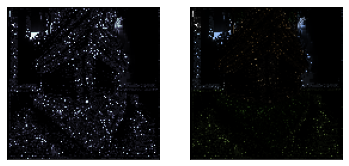

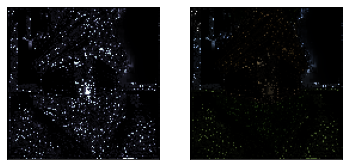

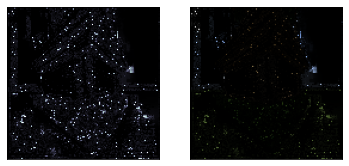

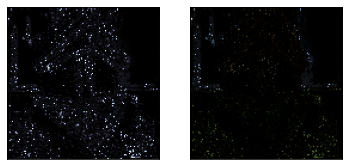

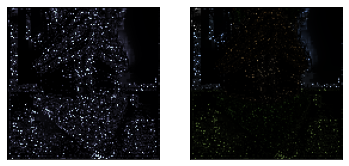

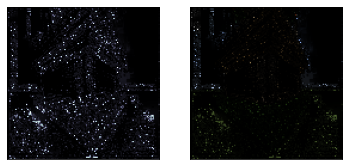

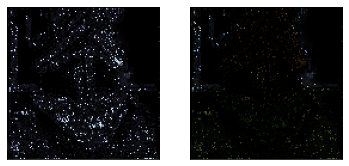

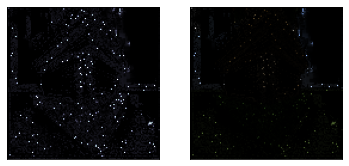

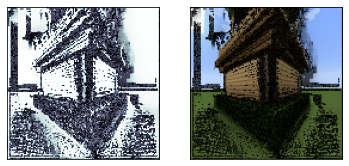

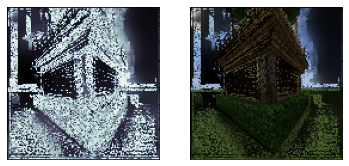

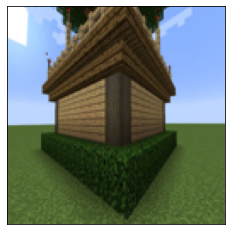

In [186]:

abstract_scene = outputs["abstract_scene"][-1]
level_masks = abstract_scene["masks"]

print(level_masks.shape)
base_mask = level_masks.detach()
print(base_mask.max())

b = 0
for i in range(base_mask.shape[1]):
    plt.subplot(1, 2, 1);plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False);
    plt.imshow(base_mask[b,i], cmap="bone")
    plt.subplot(1, 2, 2);plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False);

    plt.imshow(base_mask[b,i].unsqueeze(-1) * ims[0])
    #bx = base_locs[i] / 128
    #by = base_locs[i] % 128
    #plt.scatter(bx,by)
    plt.pause(0.01)
plt.show()

for b in range(B):
    plt.subplot(1, B, b + 1);plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False); plt.imshow(ims[b,:,:,:])
plt.show()

In [ ]:


location = (23,60)
location = (55,60)
idx = location[0] + location[1] * 128

sample_features = base_features[idx:idx+1]

masks = torch.sigmoid(
                (torch.matmul(sample_features, base_features.permute(1,0)) - 0.2) / 0.02
                ).reshape([1,128,128])

plt.imshow(masks[0].detach().numpy(), cmap = "bone")
plt.scatter(location[0], location[1])
plt.show()


NameError: name 'base_features' is not defined

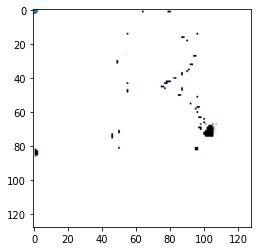

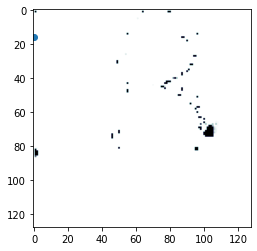

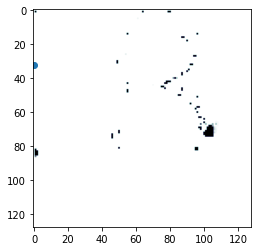

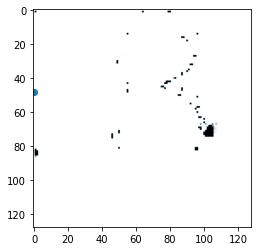

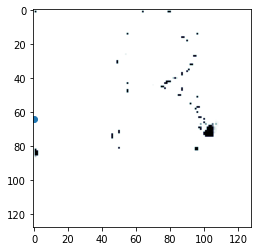

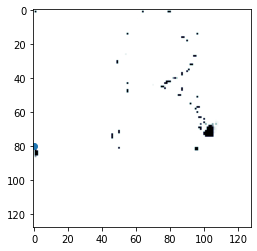

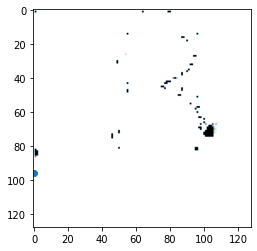

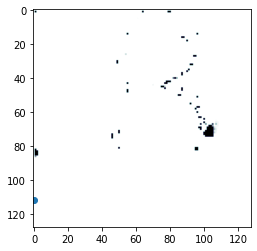

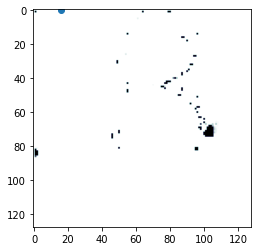

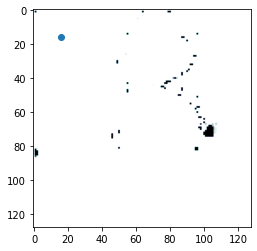

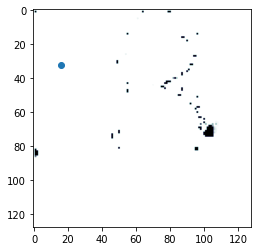

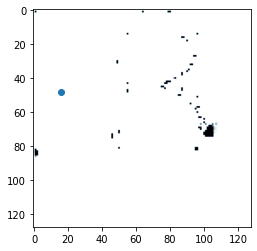

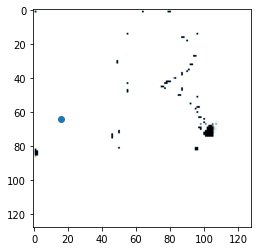

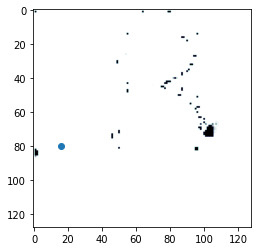

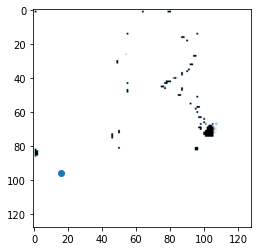

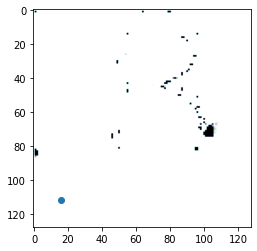

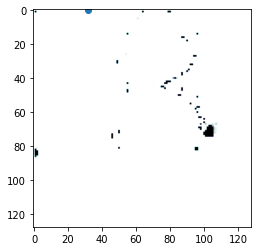

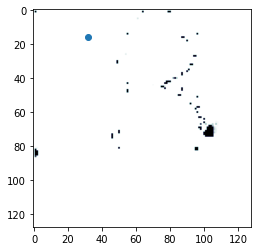

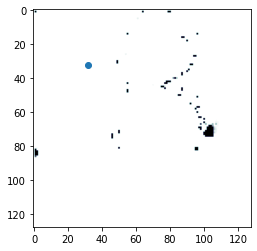

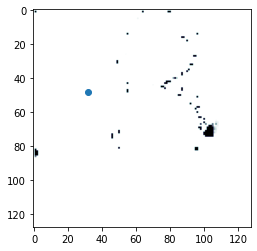

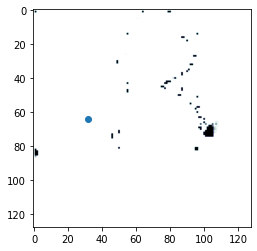

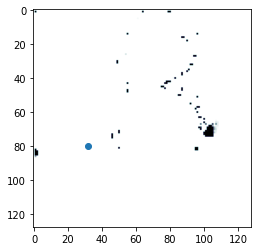

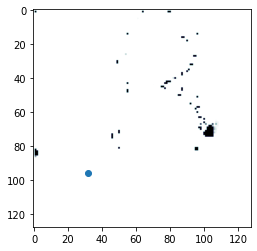

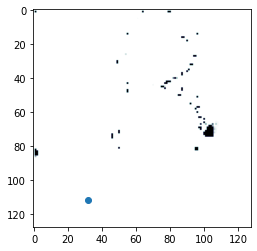

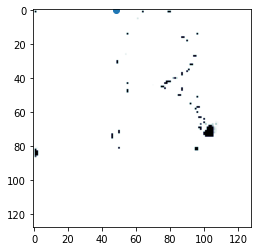

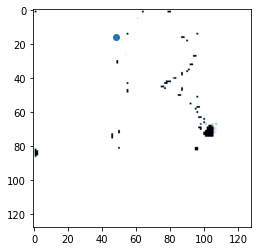

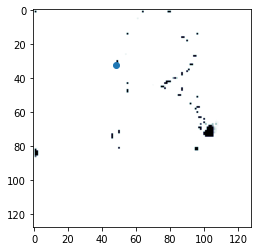

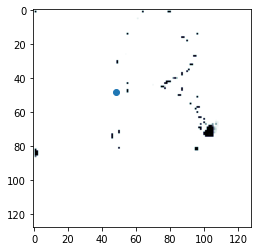

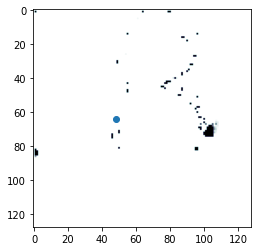

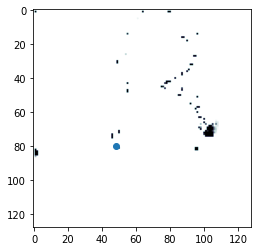

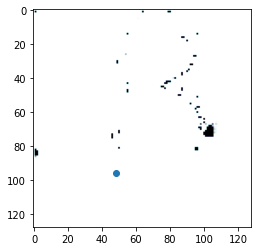

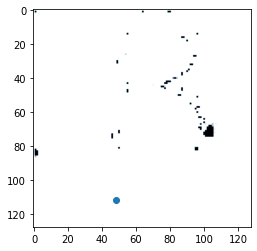

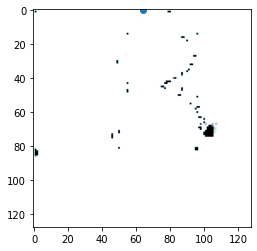

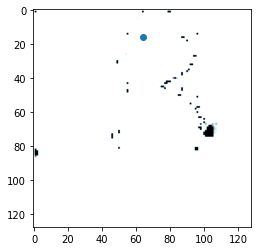

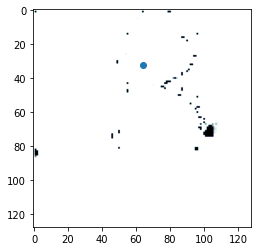

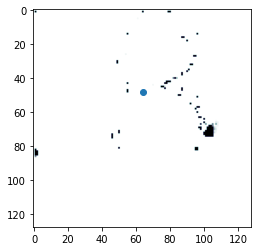

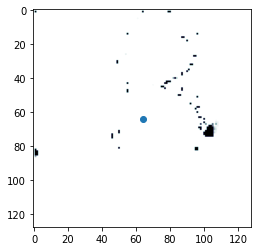

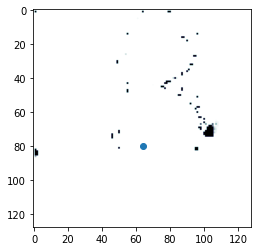

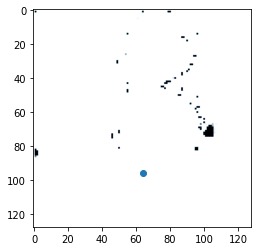

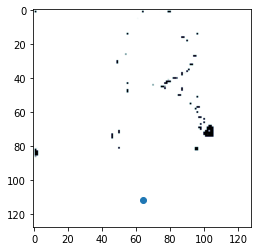

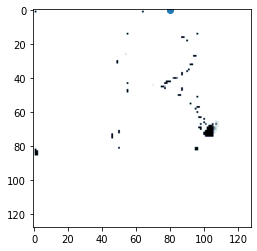

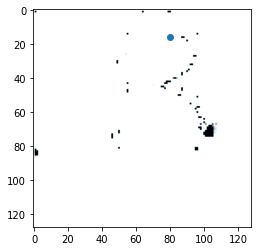

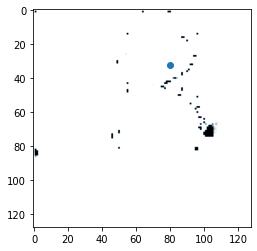

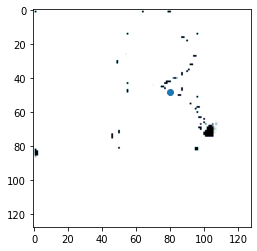

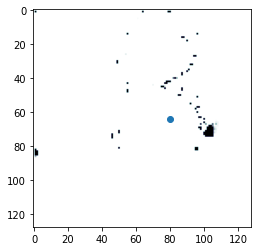

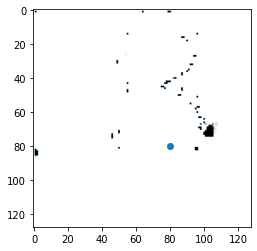

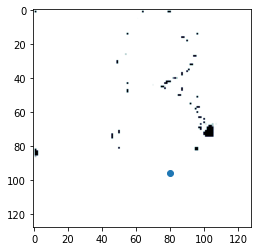

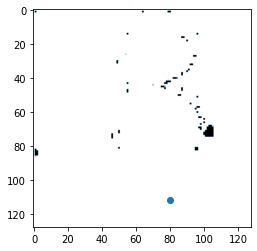

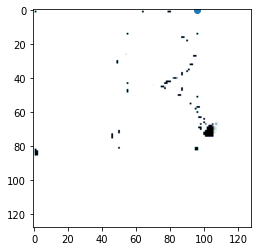

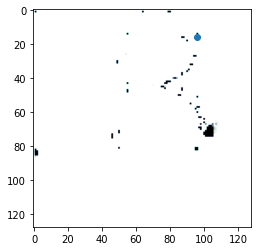

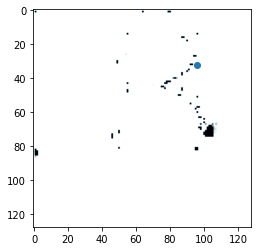

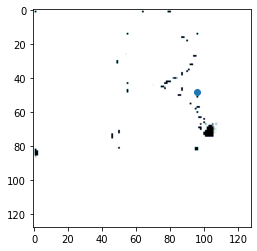

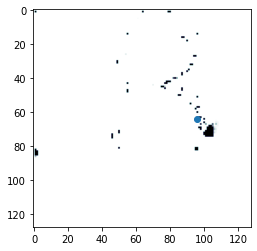

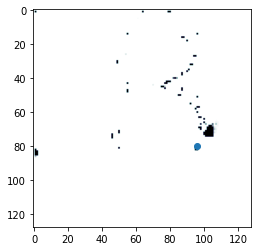

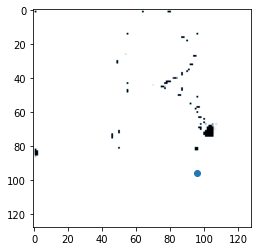

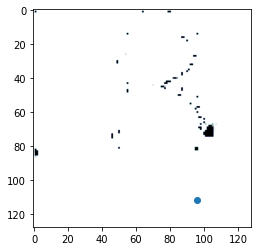

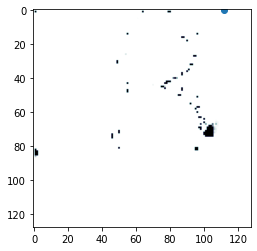

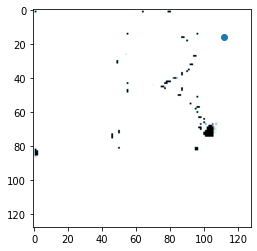

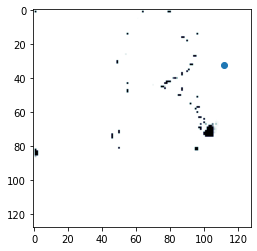

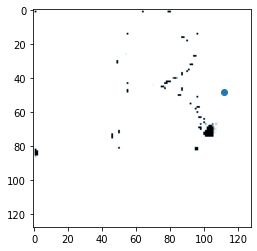

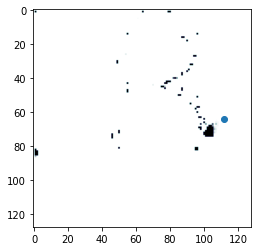

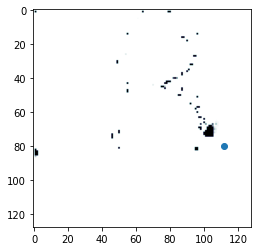

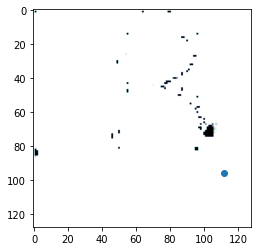

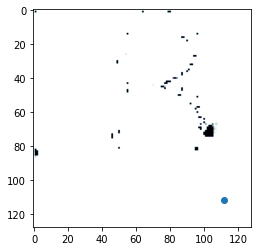

In [ ]:
base_features = level_features[0]
s = 16
for i in range(128//s):
    for j in range(128//s):
        location = (j * s, i * s)
        idx = location[0] + location[1] * 128

        sample_features = base_features[idx:idx+1]

        masks = torch.sigmoid(
                (torch.matmul(sample_features, base_features.permute(1,0)) - 0.25) / 0.02
                ).reshape([1,128,128])

        plt.imshow(masks[0].detach().numpy(), cmap = "bone")
        plt.scatter(location[1],location[0])
        plt.show()